In [1]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

#from torch import nn
from pathlib import Path
from scipy.stats import linregress
from typing import Union

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath
from Medley.utils import data_for_pcolormesh, udomains
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample

In [2]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

In [8]:
def plot_stations(stat: pd.Series, statloc: pd.DataFrame, fig = None, ax = None, cbar = True, scatter_kwargs = {}):
    try:
        s = scatter_kwargs.pop('s')
    except KeyError:
        s = 20
    if (fig is None):
        fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    lats = statloc.loc[stat.index,'LAT'].values
    lons = statloc.loc[stat.index,'LON'].values
    im = ax.scatter(x = lons, y = lats, c = stat.values, s= s, transform = ccrs.PlateCarree(), **scatter_kwargs)
    if cbar:
        fig.colorbar(im, ax = ax, shrink = 0.8)
    return fig, ax, im

def plot_plus_stations(da: xr.DataArray, stat: pd.Series = None, statloc: pd.DataFrame = None,
                       fig = None, ax = None, pcmesh_kwargs = {}, cbar = True, scatter_kwargs = {}):
    shading = 'flat'
    try:
        vmin = pcmesh_kwargs.pop('vmin')
    except KeyError:
        vmin = float(da.quantile(0.02))
    try:
        vmax = pcmesh_kwargs.pop('vmax')
    except KeyError:
        vmax = float(da.quantile(0.98))
    if (fig is None):
        fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    im = ax.pcolormesh(*data_for_pcolormesh(da, shading = shading), shading = shading, transform = ccrs.PlateCarree(),
                  vmin = vmin, vmax = vmax, **pcmesh_kwargs)
    if not (stat is None):
        scatter_kwargs.update(dict(vmin = vmin, vmax = vmax, cmap = im.cmap))
        fig, ax, _ = plot_stations(stat = stat, statloc = statloc, fig = fig, ax = ax, cbar = False, scatter_kwargs = scatter_kwargs)
    if cbar:
        fig.colorbar(im, ax = ax, shrink = 0.8)
    return fig, ax, im

## Data loading

In [9]:
rr_eobs = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v27.0e.zarr/')['rr'].compute()

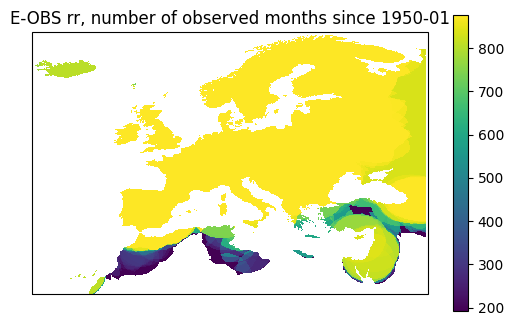

In [5]:
#test = pd.Series([90,10,50],index = [21,26074,11383])
da = rr_eobs.count('time')
da = xr.where(da == 0, np.nan, da)
#fig, ax = plot_plus_stations(da = da, stat = test, statloc = rr_ecad_locs, pcmeshkwargs={'vmin': 10,'vmax':100})
fig, ax, im = plot_plus_stations(da = da)
ax.set_title('E-OBS rr, number of observed months since 1950-01')
plt.show()

In [10]:
window = 30 # Monthly accumulation
wsd = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/1979_2021_monthly_water_surplus_deficit.zarr/')[f'spei_{window}']
lsmask = xr.open_dataarray('/scistor/ivm/jsn295/Medi/landseamask_wp3.nc')
attrs = wsd.attrs
wsd = xr.where(lsmask, wsd, np.nan).compute() # Landsea masking
wsd.attrs = attrs

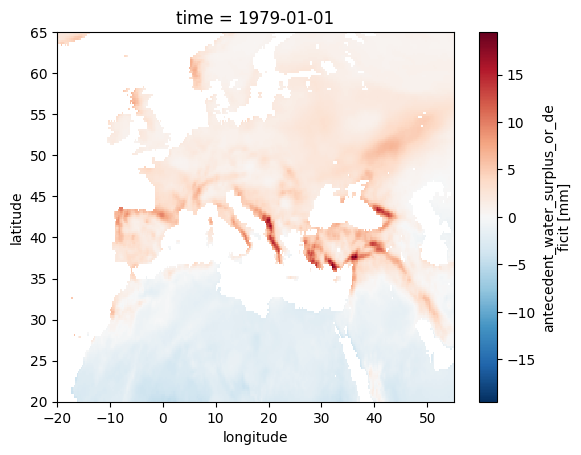

In [7]:
wsd[:,:,0].plot()

In [11]:
rr_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_RR.h5')
rr_ecad.index.name = 'time'
rr_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_RR_stations.h5')
pet_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_PET.h5')
pet_ecad.index.name = 'time'
pet_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_PET_stations.h5')
spi_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3.h5')
spi_ecad.index.name = 'time'
spi_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3_stations.h5')
cdd_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_CDD.h5')
cdd_ecad.index.name = 'time'
cdd_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_CDD_stations.h5')

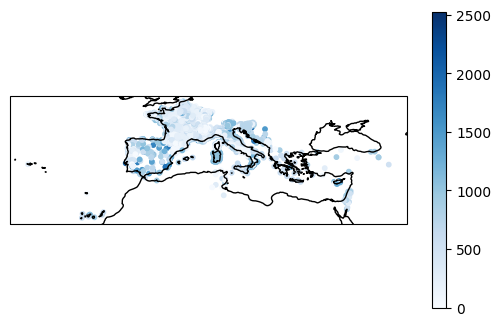

In [9]:
#fig, ax = plot_stations(rr_ecad.max(), rr_ecad_locs, scatter_kwargs=dict(vmin = 0, vmax = 600, cmap = 'Blues'))
fig, ax, im = plot_stations(rr_ecad.count(), rr_ecad_locs, scatter_kwargs=dict(cmap = 'Blues', s = 10))
ax.coastlines()
plt.show()

### Trend in monthly precipitation sums, per season.
note: not the seasonal mean.

In [11]:
min_count = 100 # So basically 33 seasons.
rr_ecad_1950 = rr_ecad.loc[slice('1950',None),:].stack().to_xarray()
rr_ecad_1950.attrs['units'] = 'mm'

In [12]:
datas = {'eobs':rr_eobs,'ecad':rr_ecad_1950}
seasonal_trends = {'eobs':{},'ecad':{}}
for name, data in datas.items():
    for season in np.unique(data.time.dt.season):
        subset = data.isel(time = (data.time.dt.season == season))
        seasonal_trends[name].update({season:trendfit_robust(subset, standardize=False, min_count = min_count)})
    seasonal_trends[name] = xr.Dataset(seasonal_trends[name])

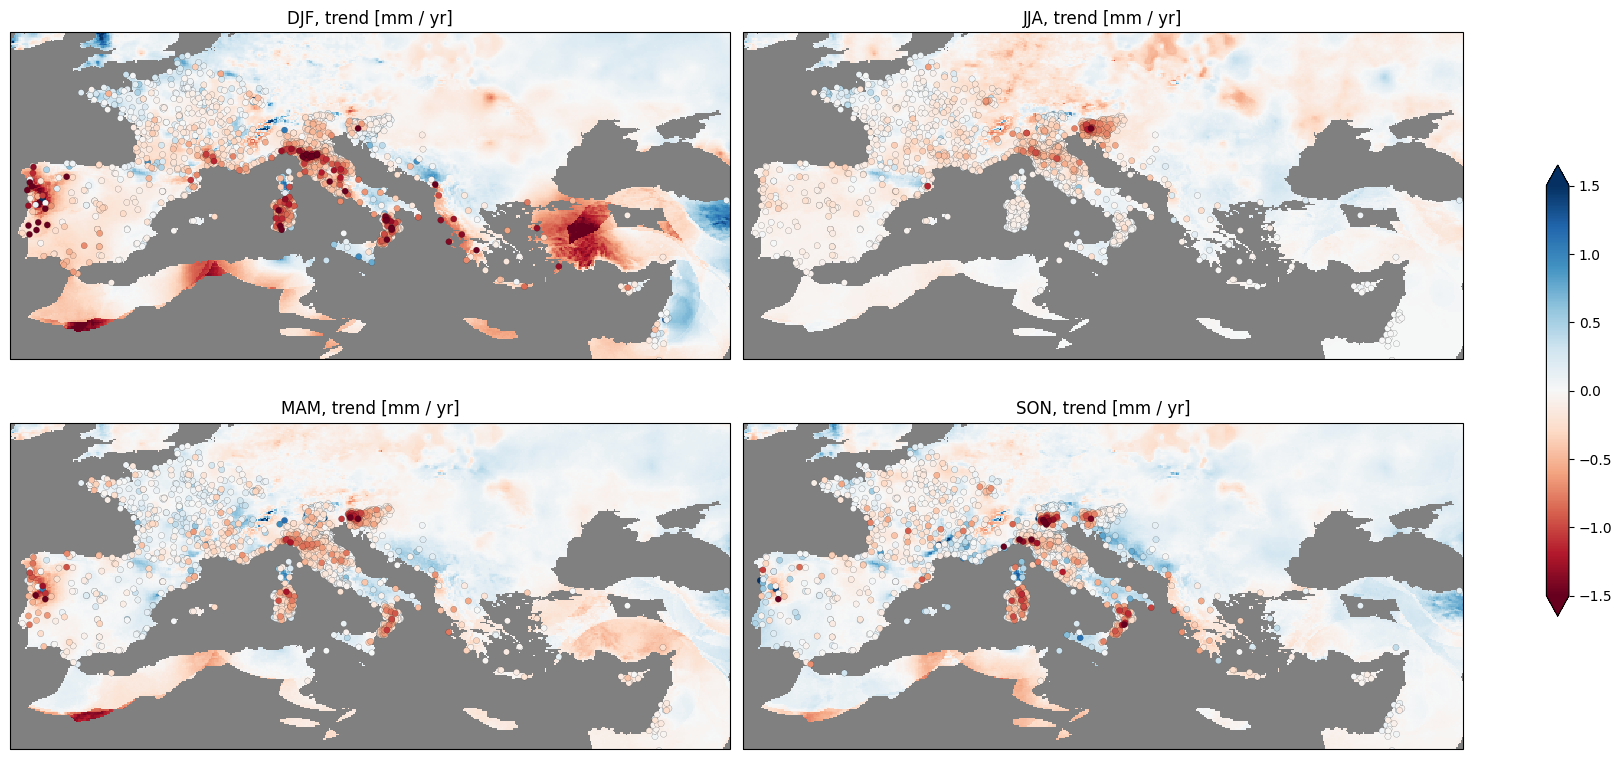

In [13]:
vmin, vmax = -1.5, 1.5
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (17,8), subplot_kw={'projection':ccrs.PlateCarree()})
for i, season in enumerate(np.unique(rr_eobs.time.dt.season)):
    ax = axes[i//2,i%2]
    ax.set_facecolor('grey')
    da = seasonal_trends['eobs'][season].sel(what = 'slope')
    stations = seasonal_trends['ecad'][season].sel(what = 'slope').to_pandas()
    stations = stations.dropna().sort_values(ascending = False)
    fig, ax, im = plot_plus_stations(da = da, stat = stations, statloc=rr_ecad_locs, fig = fig, ax = ax, 
                                   pcmesh_kwargs=dict(vmin = vmin, vmax = vmax, cmap = cmap), cbar= False,
                                    # scatter_kwargs={'s':10})
                                    scatter_kwargs={'s':20,'edgecolors':'black','linewidths':0.1})
    ax.set_title(f'{season}, trend [mm / yr]')
    ax.set_extent((-10,40,30,50))
plt.tight_layout()
cbar = fig.colorbar(im, ax = axes, extend = 'both', fraction = 0.08, shrink = 0.6)

In [99]:
# Per quarter, accumulated precip
min_count = 33 # 33 seasons
datas = {'eobs':rr_eobs.resample(time = 'QS').sum(skipna = False),'ecad':rr_ecad_1950.resample(time = 'QS').sum(skipna = False)}
quarterly_trends = {'eobs':{},'ecad':{}}
quarters = {1:'JFM',2:'AMJ',3:'JAS',4:'OND'}
for name, data in datas.items():
    for quarter, quartername in quarters.items():
        subset = data.isel(time = (data.time.dt.quarter == quarter))
        quarterly_trends[name].update({quartername:trendfit_robust(subset, standardize=False, min_count = min_count)})
    quarterly_trends[name] = xr.Dataset(quarterly_trends[name])

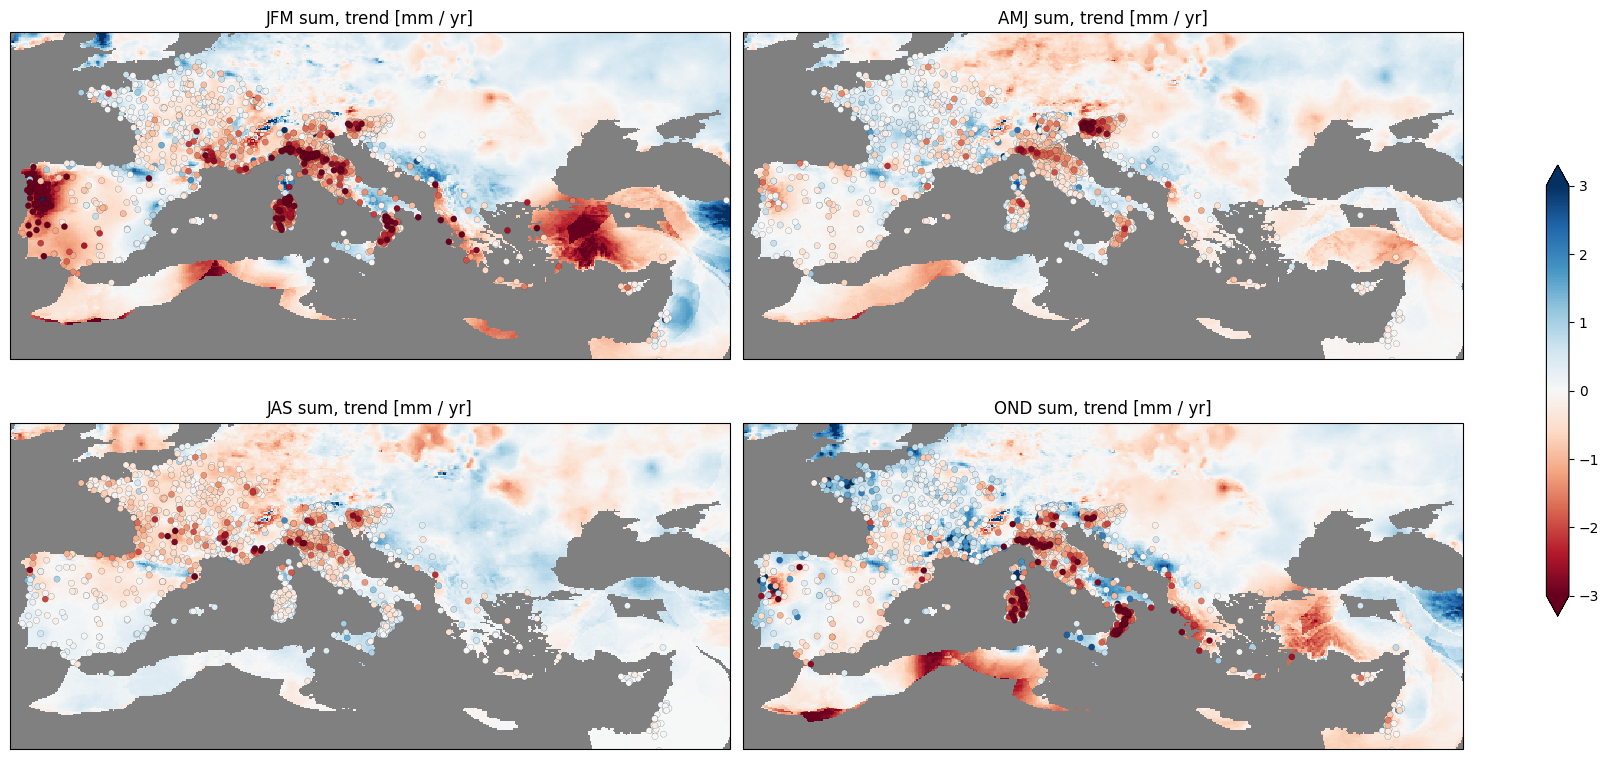

In [100]:
vmin, vmax = -3, 3
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (17,8),subplot_kw={'projection':ccrs.PlateCarree()})
for i, quarter in enumerate(quarters.values()):
    ax = axes[i//2,i%2]
    ax.set_facecolor('grey')
    da = quarterly_trends['eobs'][quarter].sel(what = 'slope')
    stations = quarterly_trends['ecad'][quarter].sel(what = 'slope').to_pandas()
    stations = stations.dropna().sort_values(ascending = False)
    fig, ax, im = plot_plus_stations(da = da, stat = stations, statloc=rr_ecad_locs, fig = fig, ax = ax, 
                                   pcmesh_kwargs=dict(vmin = vmin, vmax = vmax, cmap = cmap), cbar= False,
                                    # scatter_kwargs={'s':10})
                                    scatter_kwargs={'s':20,'edgecolors':'black','linewidths':0.1})
    ax.set_title(f'{quarter} sum, trend [mm / yr]')
    ax.set_extent((-10,40,30,50))
plt.tight_layout()
cbar = fig.colorbar(im, ax = axes, extend = 'both', fraction = 0.08, shrink = 0.6)

### Local non-linearity in trends.
Evaluated in dedicated stations, plus nearest E-OBS gridpoint.

In [120]:
counts = rr_ecad.loc[:,rr_ecad_locs.index[rr_ecad_locs['COUNTRYNAME'] == 'TURKEY']].count(axis = 0)
counts = counts.loc[counts > 400]

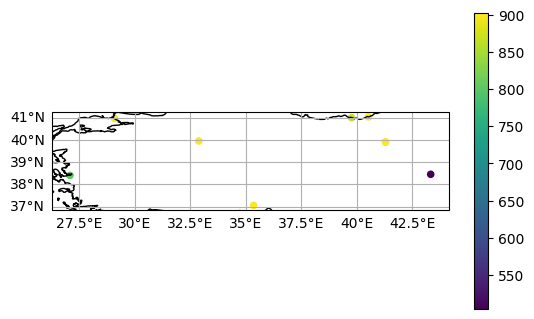

In [121]:
fig, ax, im = plot_stations(counts, statloc=rr_ecad_locs)
ax.coastlines()
ax.gridlines(draw_labels = ['left','bottom'])
plt.show()

In [122]:
rr_ecad_locs.loc[counts.index,:]

,STATIONNAME,COUNTRYNAME,LAT,LON,HGT
STAID,,,,,
245,ADANA,TURKEY,37.050000,35.350000,27
246,ANKARA,TURKEY,39.950000,32.883056,891
247,ERZURUM,TURKEY,39.900000,41.283056,1869
248,ISTANBUL,TURKEY,40.966667,29.083056,33
249,IZMIR,TURKEY,38.400000,27.083056,29
250,TRABZON,TURKEY,40.998333,39.760833,30
343,RIZE,TURKEY,41.033056,40.516667,9
957,ERZURUMBOLGE,TURKEY,39.906667,41.288056,1869
1439,VAN,TURKEY,38.450000,43.320000,1662


In [9]:
# Potential non-linearity in the trends, station ids
locs = {
    'Porto':215,
    'Madrid':230,
    'Marseille':31,
    'Bologna':169,
    'Peleponessos':840,
    'Adana':245,
    'Cyprus':498,
    'Israel':137,
}
window_length = 20

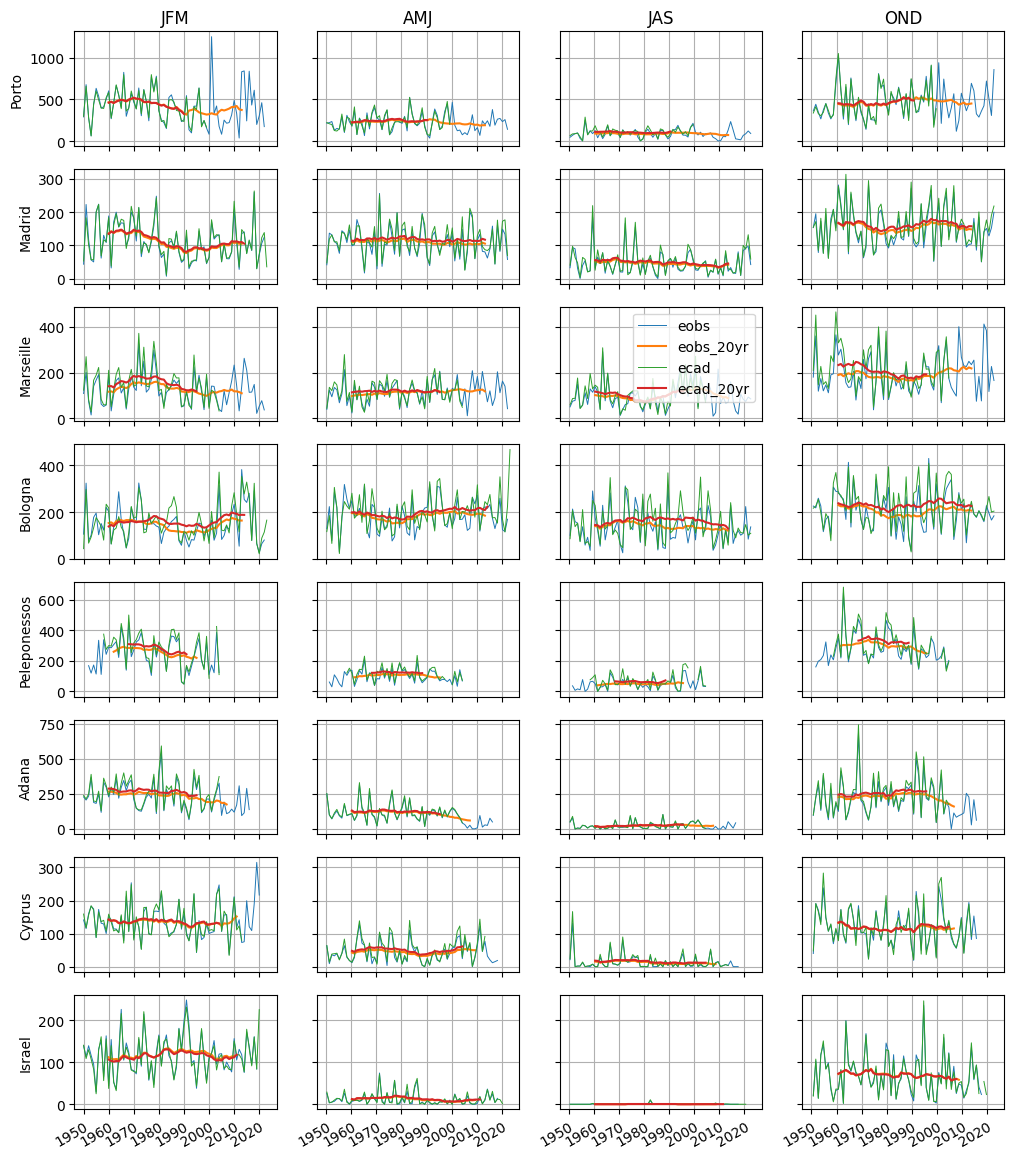

In [124]:
fig, axes = plt.subplots(nrows = len(locs), ncols = len(quarters), figsize = (12,14), sharex = True, sharey = 'row')
for i, (name, statid) in enumerate(locs.items()):
    lat,lon = rr_ecad_locs.loc[statid,['LAT','LON']]
    for j, (quarter, season) in enumerate(quarters.items()):
        ax = axes[i,j]
        if i == 0:
            ax.set_title(season)
        if j == 0:
            ax.set_ylabel(name)
        series = datas['eobs'].sel(latitude = lat, longitude = lon, method = 'nearest').isel(time = (datas['eobs'].time.dt.quarter == quarter))
        avg = series.rolling(time = window_length, center=True).mean()
        ax.plot(series.time, series.values, label = 'eobs', lw = 0.7)
        ax.plot(avg.time, avg.values, label = f'eobs_{window_length}yr')
        series = datas['ecad'].sel(STAID=statid).isel(time = (datas['ecad'].time.dt.quarter == quarter))
        avg = series.rolling(time = window_length, center=True).mean()
        ax.plot(series.time, series.values, label = 'ecad', lw = 0.7)
        ax.plot(avg.time, avg.values, label = f'ecad_{window_length}yr')
        if (i == 2) and (j == 2):
            ax.legend()
        ax.grid()
        if i == (len(locs) -1):
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
plt.show()

### WP3 WSD investigation
WSD 30 day accumulation (negative is dryer)
comparing against ECAD SPI or PET?

In [148]:
min_count = 20
#against = spi_ecad
#against_locs = spi_ecad_locs
against = -pet_ecad # Such that decrease is dryer.
against_locs = pet_ecad_locs
against_1979 = against.loc[slice('1979',None),:].stack().to_xarray()
#against_1979.attrs['units'] = '-'
against_1979.attrs['units'] = 'mm'

In [149]:
datas = {'wp3':wsd,'ecad':against_1979}
quarterly_trends = {'wp3':{},'ecad':{}}
for name, data in datas.items():
    for quarter, quartername in quarters.items():
        subset = data.isel(time = (data.time.dt.quarter == quarter))
        quarterly_trends[name].update({quartername:trendfit_robust(subset, standardize=True, min_count = min_count)})
    quarterly_trends[name] = xr.Dataset(quarterly_trends[name])

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, 

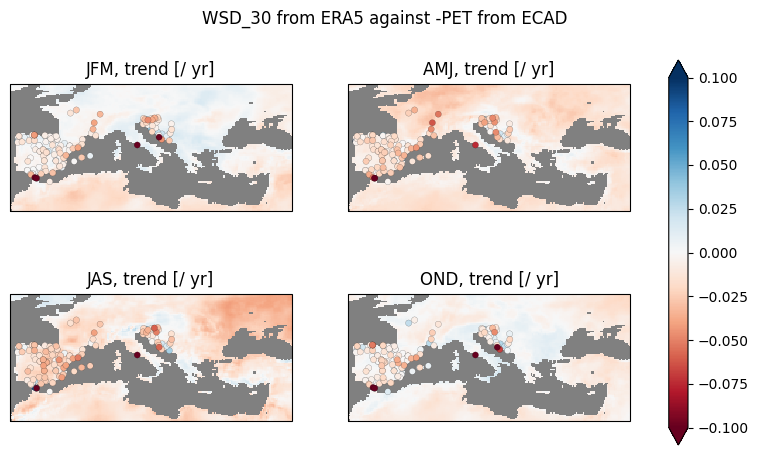

In [157]:
vmin, vmax = -.1, .1
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
for i, quarter in enumerate(quarters.values()):
    ax = axes[i//2,i%2]
    ax.set_facecolor('grey')
    da = quarterly_trends['wp3'][quarter].sel(what = 'slope')
    stations = quarterly_trends['ecad'][quarter].sel(what = 'slope').to_pandas()
    stations = stations.dropna().sort_values(ascending = False)
    fig, ax, im = plot_plus_stations(da = da, stat = stations, statloc=against_locs, fig = fig, ax = ax, 
                                   pcmesh_kwargs=dict(vmin = vmin, vmax = vmax, cmap = cmap), cbar= False,
                                    # scatter_kwargs={'s':10})
                                    scatter_kwargs={'s':20,'edgecolors':'black','linewidths':0.1})
    ax.set_title(f'{quarter}, trend [/ yr]')
    ax.set_extent((-10,40,30,50))
cbar = fig.colorbar(im, ax = axes, extend = 'both')#, fraction = 0.08, shrink = 0.3)
fig.suptitle('WSD_30 from ERA5 against -PET from ECAD')
#plt.tight_layout()
plt.show()

### Consecutive dry days
mean number per quarter
More interruption apperently, but with small precipitation amouns?
Bit less wintertime persistence?

In [179]:
cdd_1950 = cdd_ecad.loc[slice('1980',None),:].stack().to_xarray()
cdd_1950.attrs.update({'units':'days'})
cdd_1950.resample(time = 'QS').mean(skipna = False)

min_count = 33 # 33 seasons

quarterly_trend = {}
quarters = {1:'JFM',2:'AMJ',3:'JAS',4:'OND'}
for quarter, quartername in quarters.items():
    subset = cdd_1950.isel(time = (cdd_1950.time.dt.quarter == quarter))
    quarterly_trend.update({quartername:trendfit_robust(subset, standardize=False, min_count = min_count)})
quarterly_trend = xr.Dataset(quarterly_trend)

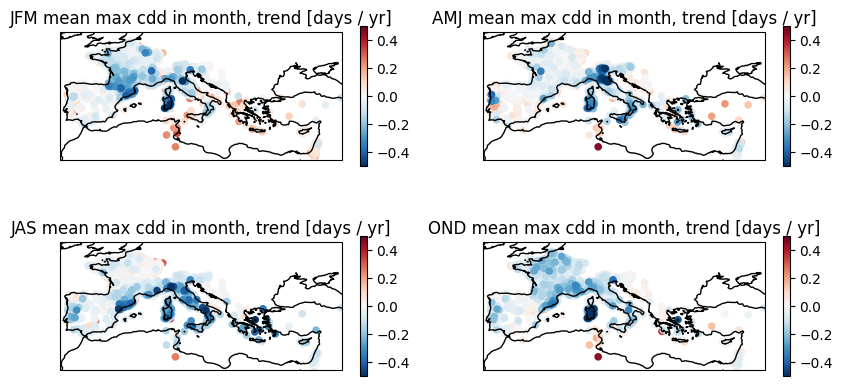

In [181]:
cmap = 'RdBu_r'
vmin, vmax = -.5, .5
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
for i, quarter in enumerate(quarters.values()):
    ax = axes[i//2,i%2]
    stations = quarterly_trend[quarter].sel(what = 'slope').to_pandas()
    stations = stations.dropna().sort_values(ascending = False)
    fig, ax, im = plot_stations(stations, cdd_ecad_locs,scatter_kwargs={'cmap':cmap, 'vmin':vmin, 'vmax':vmax}, fig = fig, ax = ax)
    ax.set_title(f'{quarter} mean max cdd in month, trend [days / yr]')
    ax.coastlines()
    ax.set_extent((-10,40,30,50))

In [ ]:
west = dict(include = {'iberia':(-9.8,35.98,3.6,43.8), 'france_italy':(4,43,13.4,45.63),},
    exclude = {'islands':(0.79,35.2,4.6,40.4),'north_africa':(-1.450,34.457,11.217,36.972),})

### Area averaging problems?

In [44]:
west = dict(include = {
                    'iberia':(-9.8,35.98,3.6,43.8),
                    'france_italy':(4,43,13.4,45.63),
                    },
               exclude = {
                   'islands':(0.79,35.2,4.6,40.4),
                   'north_africa':(-1.450,34.457,11.217,36.972),
                   })
medwest = dict(include = {
                    'iberia':(-9.8,35.98,8,44.6),
                    'italy':(8,35,18,45.63),
                    },
               exclude = {
                   'north_africa':(-1.450,34.457,11.217,36.972),
                    'eastadriatic':(15,43,20,48),
                   'tunesia':(5,30,12,38),
                   'pyrenees':(-2,41.8,3.7,45.63),
                   })
central = dict(include = {
                    'italy':(8,35,18,45.63),
                    #'france_italy':(4,43,13.4,45.63),
                    },
               exclude = {
                   'eastadriatic':(15,43,20,48),
                   'tunesia':(5,30,12,38),
                   })
centraleast = dict(include = {
                    'greeceplus':(19,34,28.5,42.7),
                    },
               exclude = {
                   #'tunesia':(5,30,12,38),
                   })
east = dict(include = {
                    'turkeycyprus':(29,32,37,38),
                    },
               exclude = {
                   #'eastadriatic':(15,43,20,48),
                   #'tunesia':(5,30,12,38),
                   })
regions = {'west':west,
               'medwest':medwest,
               'central':central,
               'centraleast':centraleast,
               'east':east}
regionmasks = {name:makemask(region) for name, region in regions.items()}

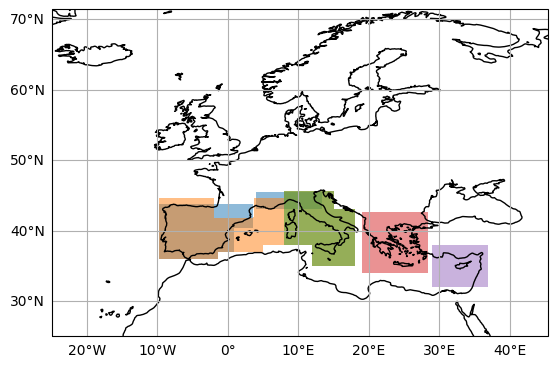

In [45]:
shading = 'nearest'
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
for i, (name, mask) in enumerate(regionmasks.items()):
    dat = xr.where(mask, mask, np.nan)
    lat, lon, dat = data_for_pcolormesh(dat, shading = shading)
    ax.contourf(lat, lon, dat, transform = ccrs.PlateCarree(), colors = list(mcolors.TABLEAU_COLORS.keys())[i], alpha = 0.5)
ax.coastlines()
ax.gridlines(draw_labels=['bottom','left'])
plt.show()

assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data


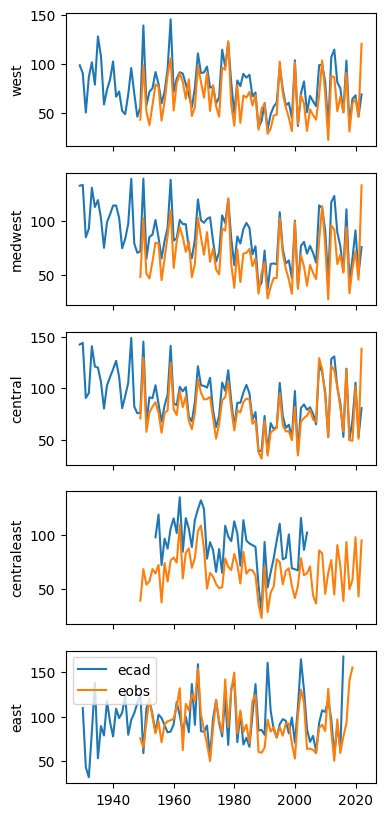

In [43]:
fig, axes = plt.subplots(nrows = len(regionmasks), figsize = (4,10), sharex = True)
start = '1930'
minsamples = 10 # Per spatial average
# temporal resampling 
for i, (name, mask) in enumerate(regionmasks.items()):
    reg_eobs = average_within_mask(mask = mask, data = rr_eobs, minsamples=minsamples)
    reg_ecad = average_within_mask(mask = mask, data = rr_ecad.loc[slice(start,None),:], datalocs=rr_ecad_locs,minsamples=minsamples)
    # temporal resampling
    djfm_ecad, djfm_eobs, cal = simultaneous_resample(X = reg_ecad.to_frame(name = 'ecad'), y=reg_eobs.to_frame(name = 'eobs'),firstmonth=12,lastmonth=3)
    ax = axes[i]
    ax.plot(djfm_ecad.index.get_level_values('anchor_year'), djfm_ecad, label = djfm_ecad.columns[0])
    ax.plot(djfm_eobs.index.get_level_values('anchor_year'), djfm_eobs, label = djfm_eobs.columns[0])

    ax.set_ylabel(name)
axes[-1].legend()

Weird wettening in the west and central west after 2000 again. Needs explanation. Jump in AMO starting at 1995, plateau-ing in and after 2000.

Overall notes on months:
* Little to no drying in Oktober and November for western and central Med, according to RR and according november SPI3 (i.e. the previous three months).
* April according the RR drops with the trend break.
* Greece drying is more consistent accross months (shorter data coverage).
And according monthly RR probably not in April and certainly not May (outlier there).
Plot below shows that the temporal wettening is in february and march, but that these months are still drying overall.



assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data


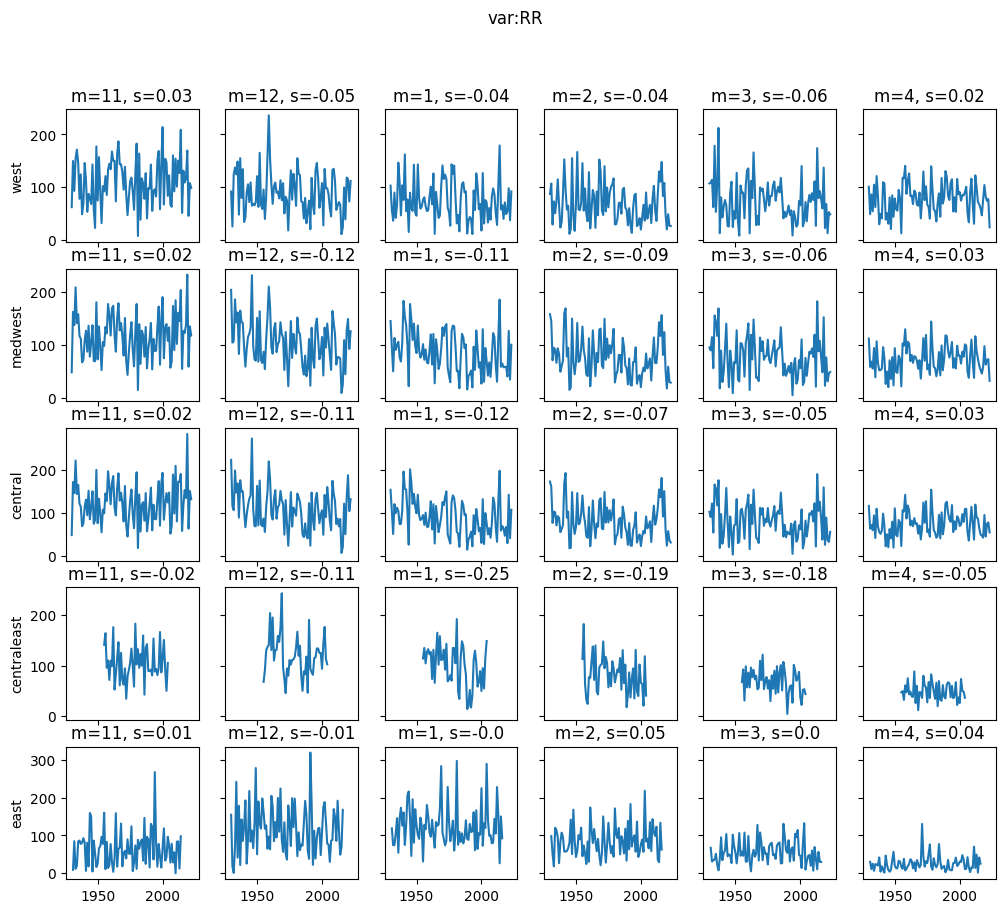

In [75]:
months = [11,12,1,2,3,4]
var = 'RR'
start = '1930'
fig, axes = plt.subplots(nrows = len(regionmasks), ncols = len(months), figsize = (12,10), sharex = True, sharey='row')
for i, (name, region) in enumerate(regions.items()):
    rr=prep_ecad(target_region=region,target_var = var,minsamples = 10)
    rr = rr.loc[slice(start,None)]
    for j, m in enumerate(months):
        rrmon = rr.loc[rr.index.month == m]
        slope = float(trendfit_robust(rrmon.to_xarray(), standardize=True).sel(what = 'slope')) * 10 # Std/decade
        ax = axes[i,j]
        ax.plot(rrmon.index.year, rrmon)
        ax.set_title(f'm={m}, s={np.round(slope,2)}')
        if j == 0:
            ax.set_ylabel(name)
fig.suptitle(f'var:{var}')
plt.show()

assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data


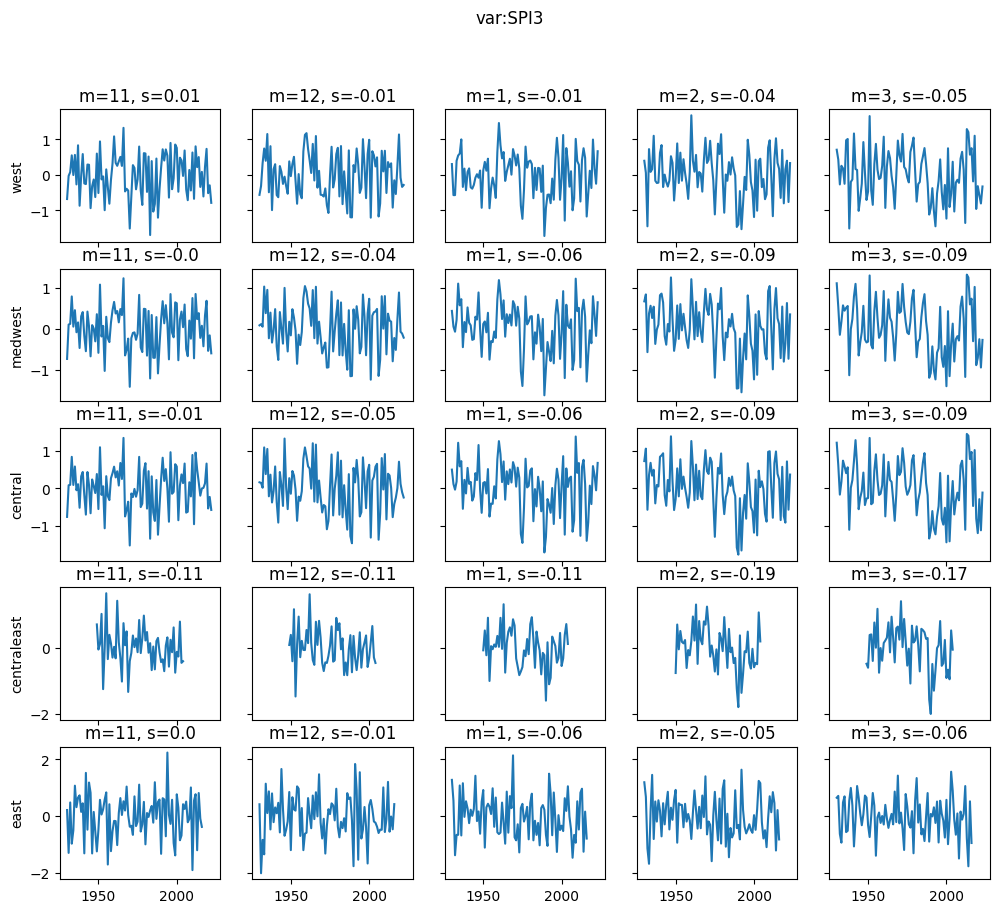

In [77]:
months = [11,12,1,2,3]
#months = np.arange(1,5)
var = 'SPI3'
start = '1930'
fig, axes = plt.subplots(nrows = len(regionmasks), ncols = len(months), figsize = (12,10), sharex = True, sharey='row')
for i, (name, region) in enumerate(regions.items()):
    rr=prep_ecad(target_region=region,target_var = var,minsamples = 5)
    rr = rr.loc[slice(start,None)]
    for j, m in enumerate(months):
        rrmon = rr.loc[rr.index.month == m]
        slope = float(trendfit_robust(rrmon.to_xarray(), standardize=True).sel(what = 'slope')) * 10 # Std/decade
        ax = axes[i,j]
        ax.plot(rrmon.index.year, rrmon)
        ax.set_title(f'm={m}, s={np.round(slope,2)}')
        if j == 0:
            ax.set_ylabel(name)
fig.suptitle(f'var:{var}')
plt.show()

### Distributional properties.
For the different regions and target variables.
monthly target is clearly bounded at zero, and non-normal.

assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data


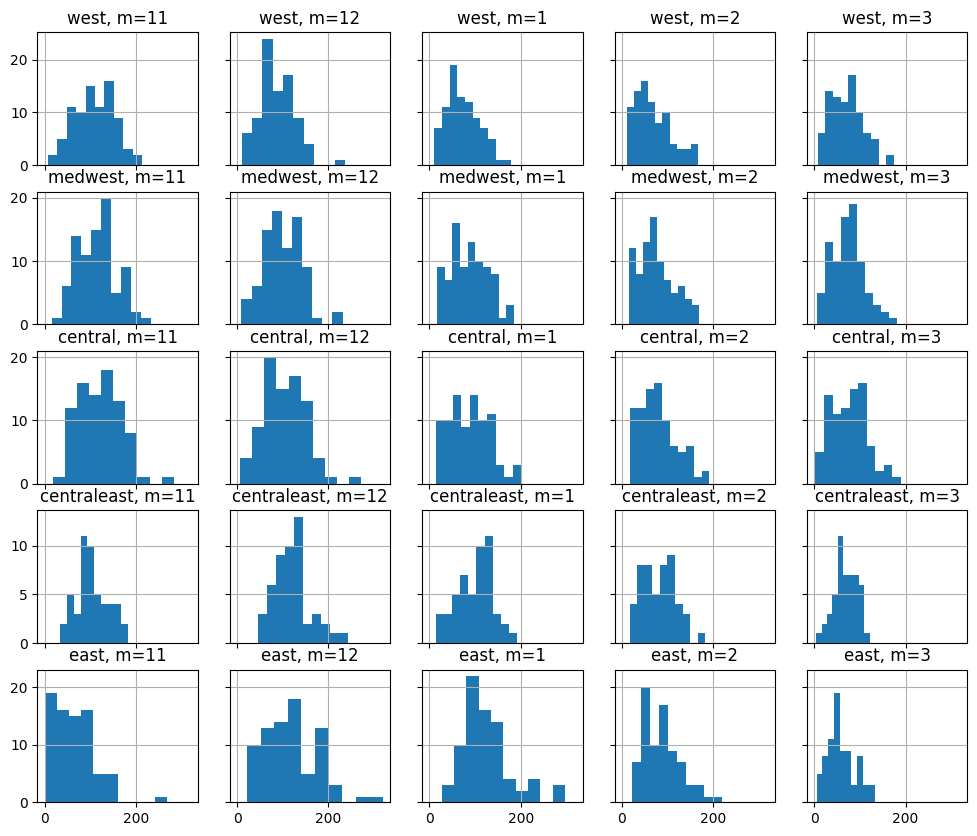

In [55]:
months = [11,12,1,2,3]
start = '1939'
var = 'RR'
fig, axes = plt.subplots(nrows = len(regionmasks), ncols = len(months), figsize = (12,10), sharex = True, sharey='row')
for i, (name, region) in enumerate(regions.items()):
    rr=prep_ecad(target_region=region,target_var = var,minsamples = 10)
    rr = rr.loc[slice(start,None)]
    for j, m in enumerate(months):
        rrmon = rr.loc[rr.index.month == m]
        ax = axes[i,j]
        rrmon.hist(ax = ax)
        ax.set_title(f'{name}, m={m}')

assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data
assuming station data


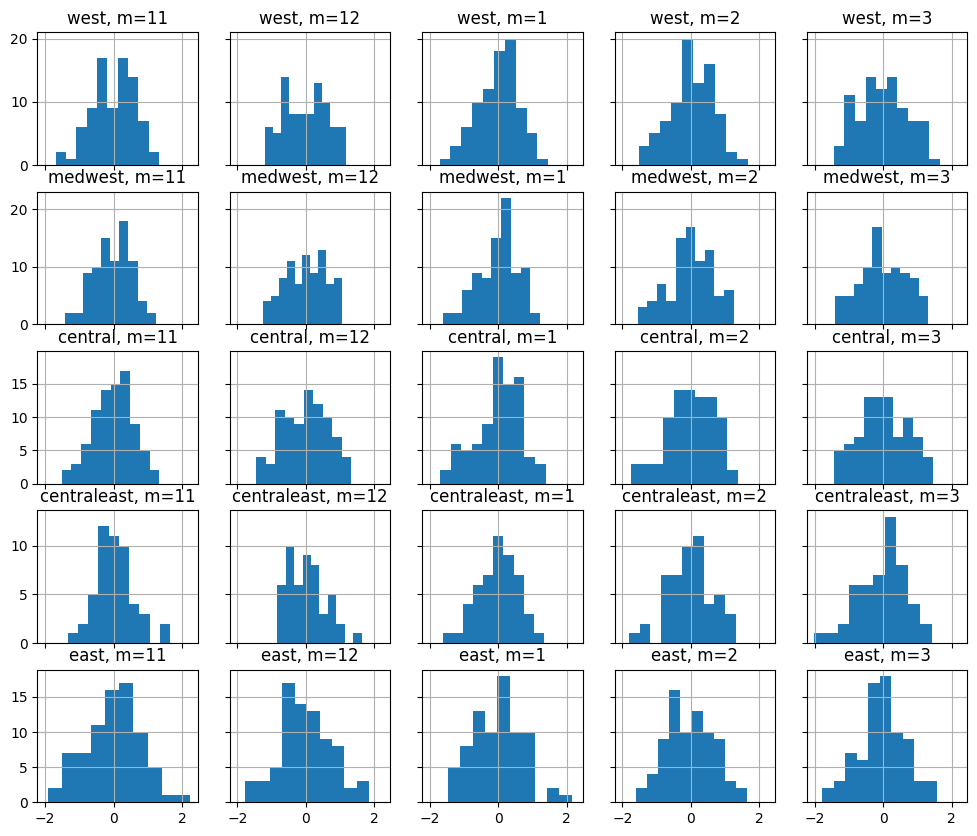

In [57]:
months = [11,12,1,2,3]
start = '1939'
var = 'SPI3'
fig, axes = plt.subplots(nrows = len(regionmasks), ncols = len(months), figsize = (12,10), sharex = True, sharey='row')
for i, (name, region) in enumerate(regions.items()):
    rr=prep_ecad(target_region=region,target_var = var,minsamples = 10)
    rr = rr.loc[slice(start,None)]
    for j, m in enumerate(months):
        rrmon = rr.loc[rr.index.month == m]
        ax = axes[i,j]
        rrmon.hist(ax = ax)
        ax.set_title(f'{name}, m={m}')

## U-wind climatology and trends.
at 250 and 500 hPa.

In [14]:
levels = [250,500]
ds = xr.Dataset()
for name, (lonmin, lonmax) in udomains.items():
    arrays = []
    for level in levels:
        da = xr.open_dataarray((datapath / f'monthly_zonalmean_u{level}_NH_{lonmin}E_{lonmax}E.nc'))
        da.coords['level'] = level
        arrays.append(da)
    ds.update({name:xr.concat(arrays,dim = 'level')})

In [32]:
seas_clim = ds.groupby(ds.time.dt.month).mean()

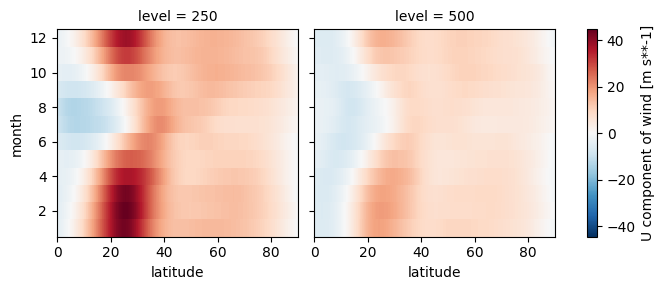

In [33]:
seas_clim['med'].plot(col = 'level')

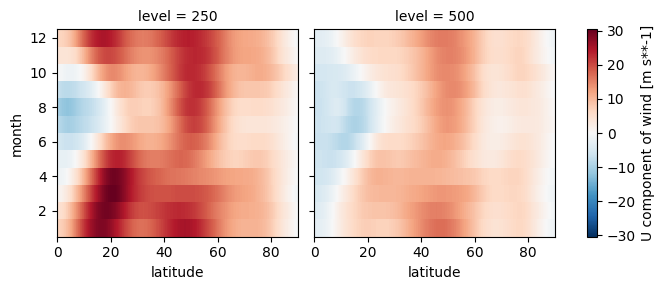

In [34]:
seas_clim['atl'].plot(col = 'level')

This double signal at 250, pleads for using 500 to detect eddy-driven jet over atlantic, cleaner tracing of the maximum. At 250 the atlantic is jumpy:

In [46]:
latmax = ds.idxmax('latitude')

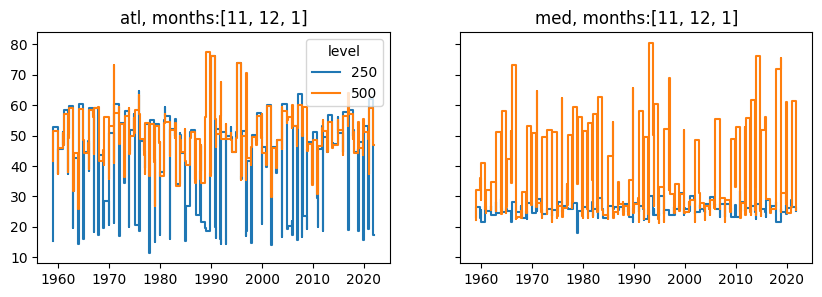

In [73]:
months = [11,12,1] # [12,1,2] DJF
fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (10,3))
for i, name in enumerate(['atl','med']):
    ax = axes[i]
    data = latmax[name].isel(time = [m in months for m in latmax.time.dt.month])
    for level in [250,500]:
        ax.step(data.time, data.sel(level = level).values, label = level)
    ax.set_title(f'{name}, months:{months}')
axes[0].legend(title = 'level')

No big northward trend for the subtropical jet in the mediterranean at 250, at least not for the maximum. Also variability is lower than for the eddy driven jet.
#### Trends in speed

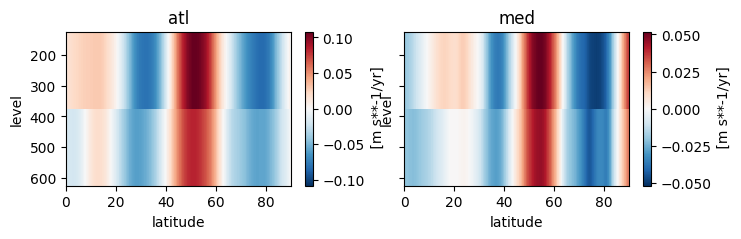

In [99]:
#vmin, vmax = -0.05, 0.05
season = "DJF"
slopes = {name:compute_trends(ds[name].sel(time = ds.time.dt.season == season)).sel(what = 'slope') for name in ['atl','med']}
#atlslope = compute_trends(ds['atl'])
fig, axes = plt.subplots(ncols = 2, figsize = (8,2), sharex = True, sharey= True)
for i, name in enumerate(['atl','med']):
    ax = axes[i]
    slopes[name].plot(ax = ax, cmap = 'RdBu_r')
    ax.set_title(name)
    ax.invert_yaxis()

If sub-tropical jet and eddy driven jet are both strengthening, they should at least be anti-correlated in terms of year-to-year variability, according to Aarnouts theory.

More of a barotropic trend in the atlantic. Some strengthening of subtropical jet at 250. Is it a northward movement? Trend at midlat is highest but windspeeds will actually be lower there.